In [1]:
%load_ext dotenv
%dotenv
%load_ext mypy_ipython

In [2]:
from langgraph.graph import START, END, StateGraph, MessagesState
from langchain_openai.chat_models import AzureChatOpenAI
from langchain_core.messages import AIMessage, HumanMessage, BaseMessage, RemoveMessage, SystemMessage
from langgraph.checkpoint.memory import InMemorySaver
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

In [3]:
class State(MessagesState):
    summary: str

In [4]:
llm = AzureChatOpenAI(
    azure_deployment="gpt-4o",
    api_version="2024-06-01",
    temperature=0.5
)

In [5]:
def ask_q(state:State) -> State:
    print(f"\n---------------->ENTERING ask_q()")
    q = "What's your question?"
    print(q)
    # この input() には、ユーザーが入力した内容が入る
    return State(messages=[AIMessage(q), HumanMessage(input())])

In [6]:
state = State(messages=[])
result = ask_q(state)
print(f"result: {result}")


---------------->ENTERING ask_q()
What's your question?
result: {'messages': [AIMessage(content="What's your question?", additional_kwargs={}, response_metadata={}), HumanMessage(content='where was he born?', additional_kwargs={}, response_metadata={})]}


In [7]:
def chatbot(state: State) -> State:
    print(f"\n---------------->ENTERING chatbot()")
    system_message = f'''
    Here's a quick summary of what's been discussed so far:
    {state.get("summary","")}
    
    Keep this in mind as you answer next question
    '''
    # print(f"state: {state}")
    # state は Dict 型なので、state["messages"] のようにアクセスする
    res = llm.invoke([SystemMessage(content=system_message)] + state["messages"])
    res.pretty_print()
    
    return State(messages=[res])

In [8]:
chatbot(state)


---------------->ENTERING chatbot()
================================== Ai Message ==================================

Sure! Please go ahead and ask your next question. I'll do my best to help!


{'messages': [AIMessage(content="Sure! Please go ahead and ask your next question. I'll do my best to help!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 33, 'total_tokens': 52, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-C8nAqeX9xKmSADz2jFM8XKKTEhIoy', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}, id='run--eb928bcb-3ff8-4e7d-9585-0c6df4ae9e58

In [9]:
def summarize(state:State) -> State:
    print(f"\n---------------->ENTERING summarize()")
    
    new_conversation = ""
    for i in state["messages"]:
        if isinstance(i, RemoveMessage):
            continue
        new_conversation += f"{i.type}: {i.content}\n"
    print(f"new_conversation: {new_conversation}")
    
    summary_instruction = f'''
    Respond only with the summary
    Previous Summary:
    {state.get("summary","")}

    New Conversation: {new_conversation}
    '''
    
    print(summary_instruction)
    
    res = llm.invoke([SystemMessage(content=summary_instruction)] + state["messages"])
    res.pretty_print()

    remove_messages = [RemoveMessage(id = i.id) for i in state["messages"][:]]
    return State(messages=remove_messages, summary=res.content)

In [10]:
summarize(state)


---------------->ENTERING summarize()
new_conversation: 

    Respond only with the summary
    Previous Summary:
    

    New Conversation: 
    
================================== Ai Message ==================================

Sure! How can I assist you today?


{'messages': [], 'summary': 'Sure! How can I assist you today?'}

In [11]:
graph = StateGraph(State)
graph.add_node("ask_q", ask_q)
graph.add_node("chatbot", chatbot)
graph.add_node("summarize", summarize)

graph.add_edge(START, "ask_q")
graph.add_edge("ask_q", "chatbot")
graph.add_edge("chatbot", "summarize")
graph.add_edge("summarize", END)

In [12]:
db_path = './sqlite/test.db'
con = sqlite3.connect(db_path, check_same_thread=False)

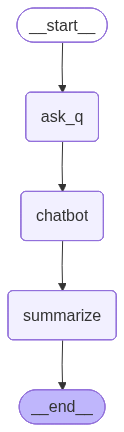

In [13]:
# checkpoint = InMemorySaver()
checkpointer = SqliteSaver(con)

graph_compiled = graph.compile(checkpointer)
graph_compiled

In [14]:
config1 = {"configurable":{"thread_id":"1"}}

In [15]:
graph_compiled.invoke(State(),config1)


---------------->ENTERING ask_q()
What's your question?

---------------->ENTERING chatbot()
================================== Ai Message ==================================

Guido van Rossum was born in **The Hague**, Netherlands, on **January 31, 1956**.

---------------->ENTERING summarize()
new_conversation: ai: What's your question?
human: where was he born?
ai: Guido van Rossum was born in **The Hague**, Netherlands, on **January 31, 1956**.


    Respond only with the summary
    Previous Summary:
    The creator of the Python programming language is **Guido van Rossum**, a Dutch programmer, who first released it in 1991.

    New Conversation: ai: What's your question?
human: where was he born?
ai: Guido van Rossum was born in **The Hague**, Netherlands, on **January 31, 1956**.

    
================================== Ai Message ==================================

Guido van Rossum was born in **The Hague**, Netherlands.


{'messages': [],
 'summary': 'Guido van Rossum was born in **The Hague**, Netherlands.'}

In [16]:
graph_state = graph_compiled.get_state_history(config1)

In [17]:
graph_state

<generator object Pregel.get_state_history at 0x000001F1972DCB40>